<a href="https://colab.research.google.com/github/Vietanh239/CIFAR10/blob/main/Simple_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Thư viện

In [ ]:
import numpy as np
import torch 
import torch.nn
import torch.nn.functional as F
import torchvision as tv
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline
#--------------------------------Thư viện cần thiết cho vẽ ------------------
from __future__ import division, print_function, unicode_literals
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
np.random.seed(5)
from torchvision import transforms

In [ ]:
!git clone https://github.com/waleedka/hiddenlayer.git

Cloning into 'hiddenlayer'...
remote: Enumerating objects: 364, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 364 (delta 2), reused 6 (delta 0), pack-reused 355
Receiving objects: 100% (364/364), 4.47 MiB | 22.77 MiB/s, done.
Resolving deltas: 100% (183/183), done.


In [ ]:
import hiddenlayer.hiddenlayer as hl


**Hằng số mặc định**

In [ ]:
MODELNAME = "cifar.model"
EPOCH = 30
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load Data

**train và test**

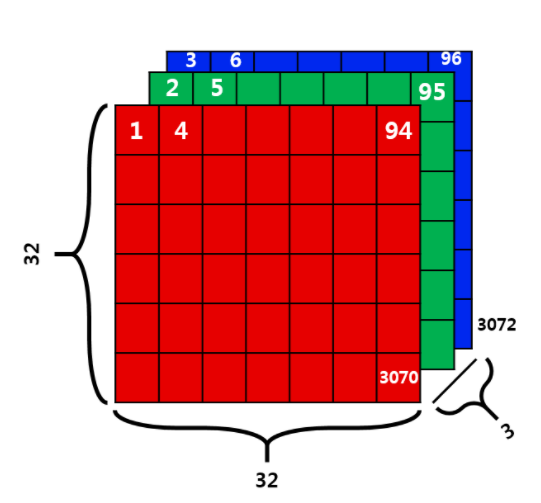

In [ ]:
class Loader_Data():
  def __init__(self):
    
    # load the dataset
    train_dataset = CIFAR10(root='./', train=True, download=True, transform=transforms.ToTensor() )
    self.train_dataset=train_dataset
    self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)

    self.test_dataset = CIFAR10(root='./', train=False,transform=transforms.ToTensor(),download = True)
    self.test_loader = DataLoader(dataset=self.test_dataset, batch_size=100, shuffle=False) #Test
    print("Bộ CIFAR có : {} dữ liệu Train, {} dữ liệu test".format(len(train_dataset),len(self.test_dataset)))

    self.classes=['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
  def Show_img(self):
    dataiter = iter(self.train_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    # display 20 images
    for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      img = images[idx].copy() / 2 + 0.5  
      plt.imshow(np.transpose(img, (1, 2, 0)))  
      ax.set_title(self.classes[labels[idx]])    
  def Show_Graph_Train(self):
    num_each_class={'airplane':0, 'automobile':0, 'bird':0, 'cat':0, 'deer':0,'dog':0, 'frog':0, 'horse':0, 'ship':0, 'truck':0}
    values=[]
    dataiter = iter(self.train_loader)
    images, labels = dataiter.next()
    for i,j in self.train_dataset:
      num_each_class[self.classes[j]]+=1

    for i,j in num_each_class.items():
      print("Class {} have {} objects".format(i,j))
      values.append(j)
    names=self.classes
    plt.figure(figsize=(30, 3))
    plt.subplot(131)
    plt.bar(names, values)
    plt.subplot(132)
    plt.scatter(names, values)
    plt.subplot(133)
    plt.plot(names, values)
    plt.suptitle('Train Plotting')
    plt.show()
  def Show_Graph_Test(self):
    num_each_class={'airplane':0, 'automobile':0, 'bird':0, 'cat':0, 'deer':0,'dog':0, 'frog':0, 'horse':0, 'ship':0, 'truck':0}
    values=[]
    for i,j in self.test_dataset:
      num_each_class[self.classes[j]]+=1
    for i,j in num_each_class.items():
      print("Class {} have {} objects".format(i,j))
      values.append(j)
    names=self.classes
    plt.figure(figsize=(30, 3))
    plt.subplot(131)
    plt.bar(names, values)
    plt.subplot(132)
    plt.scatter(names, values)
    plt.subplot(133)
    plt.plot(names, values)
    plt.suptitle('Test Plotting')
    plt.show()
  def Show_Graph(self):
    self.Show_Graph_Train()
    self.Show_Graph_Test()


# Model

In [ ]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 400, 5)
    self.pool = torch.nn.MaxPool2d(2, 2)
    self.conv2 = torch.nn.Conv2d(400, 200, 5)
    self.conv3 = torch.nn.Conv2d(200, 16, 5)
    self.fc1 = torch.nn.Linear(16 * 3 * 3, 256)
    self.fc2 = torch.nn.Linear(256, 128)
    self.fc3 = torch.nn.Linear(128, 32)
    self.fc4 = torch.nn.Linear(32, 10)
    
  def forward(self, x):

    x = self.pool(F.relu(self.conv1(x)))
    x = self.conv2(x)
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    
    return x

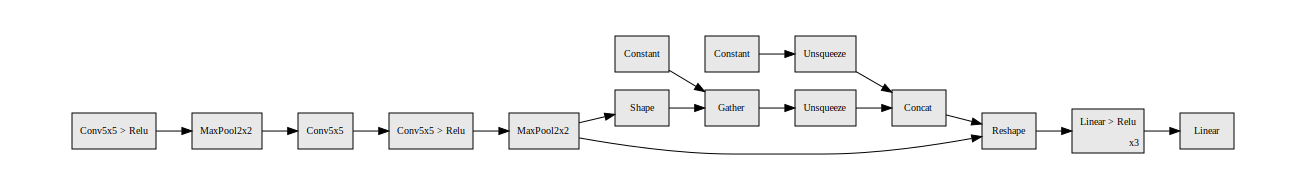

In [ ]:
hl.build_graph(Net().to(DEVICE), torch.zeros([1, 3, 32, 32]).to(DEVICE))

## Xây dựng CheckPoint

## Xây dựng quá trình Train và test

In [ ]:
import torch.nn as nn
cifar_canvas = hl.Canvas()
cifar_history = hl.History()
class TRAIN_MODEL:
  def __init__(self,data_loader,EPOCH=10,patience=3):
    self.data_loader=data_loader
    self.model = Net().to(DEVICE)

    #Khởi tạo điểm Stop
    self.early_stopping = EarlyStopping(patience=patience, verbose=True)

    ##Batch loss
    self.batch_train_loss=[]
    self.EPOCH=EPOCH
    

  def train(self):

    optimizer = torch.optim.Adam(self.model.parameters())
    for epoch in range(self.EPOCH):
        # để theo dõi TrainLoss khi mô hình đào tạo
        train_losses = []


        ###################
        # train the model #
        ###################
        sum_train_loss=0.0
        for images, label in self.data_loader.train_loader:
          images, label = images.to(DEVICE), label.to(DEVICE)
          optimizer.zero_grad()
          output = self.model(images)
          batchloss = F.cross_entropy(output,label)
          batchloss.backward()
          sum_train_loss+= batchloss.item()
          optimizer.step()
          pred_labels = np.argmax(output.detach().cpu().numpy(), 1)
          accuracy = np.mean(pred_labels == label.detach().cpu().numpy())
          cifar_history.log(epoch,
                              loss=1-accuracy, accuracy=accuracy)
       

        
        #Add Loss
        self.batch_train_loss.append(sum_train_loss)
        print_msg = ('[{}/{}]'.format(epoch+1,self.EPOCH) + f'train loss: {sum_train_loss:.5f} ')
        
        print(print_msg)
    
    torch.save(self.model.state_dict(), MODELNAME)



Files already downloaded and verified
Files already downloaded and verified
Bộ CIFAR có : 50000 dữ liệu Train, 10000 dữ liệu test


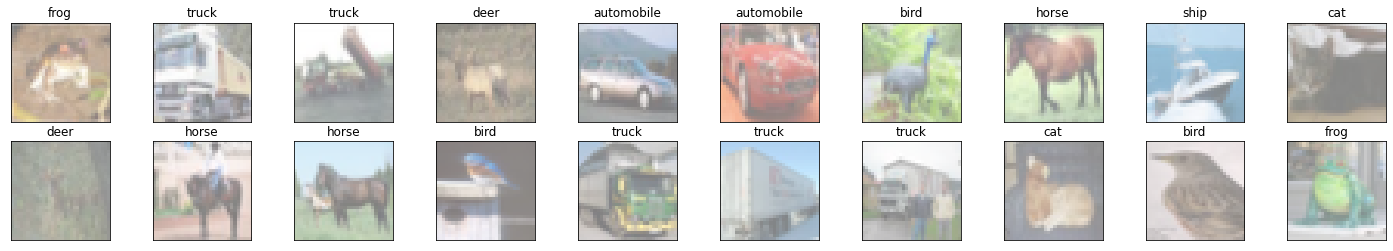

In [ ]:
Data=Loader_Data()
Data.Show_img()


Class airplane have 5000 objects
Class automobile have 5000 objects
Class bird have 5000 objects
Class cat have 5000 objects
Class deer have 5000 objects
Class dog have 5000 objects
Class frog have 5000 objects
Class horse have 5000 objects
Class ship have 5000 objects
Class truck have 5000 objects


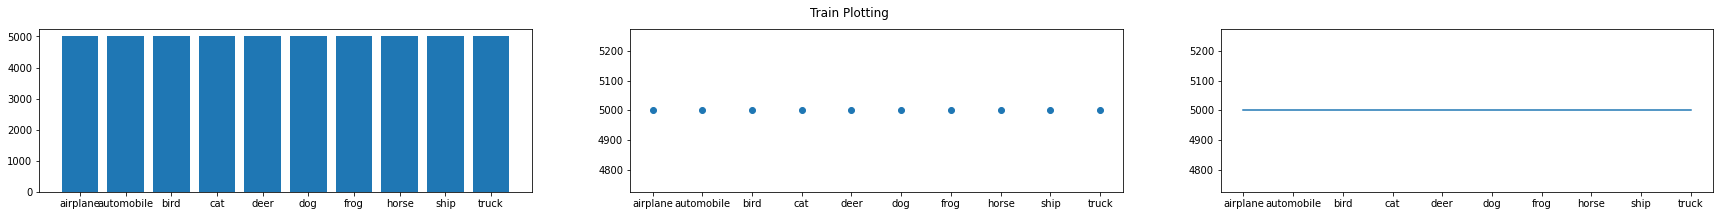

Class airplane have 1000 objects
Class automobile have 1000 objects
Class bird have 1000 objects
Class cat have 1000 objects
Class deer have 1000 objects
Class dog have 1000 objects
Class frog have 1000 objects
Class horse have 1000 objects
Class ship have 1000 objects
Class truck have 1000 objects


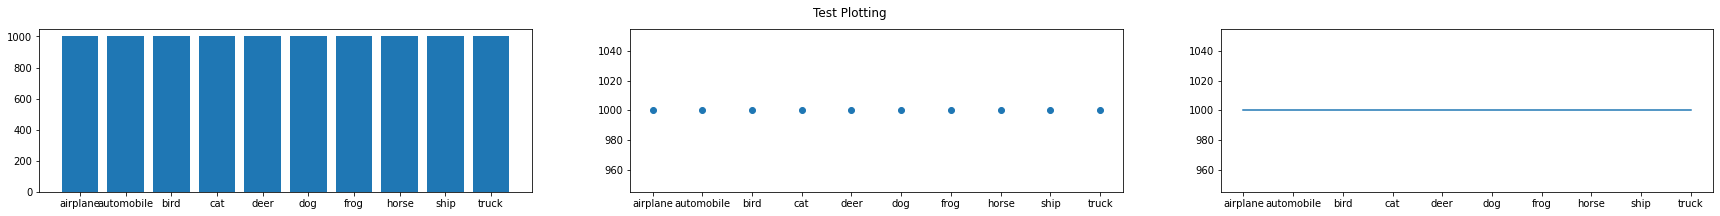

In [ ]:
Data.Show_Graph()

In [ ]:
MyModel=TRAIN_MODEL(Data,30)
MyModel.train()

[1/30]train loss: 819.80697 
[2/30]train loss: 649.77220 
[3/30]train loss: 579.85624 
[4/30]train loss: 529.19712 
[5/30]train loss: 490.09898 
[6/30]train loss: 463.96006 
[7/30]train loss: 440.71677 
[8/30]train loss: 417.72732 
[9/30]train loss: 404.27425 
[10/30]train loss: 387.83406 
[11/30]train loss: 379.59906 
[12/30]train loss: 356.90325 
[13/30]train loss: 345.99938 
[14/30]train loss: 330.91566 
[15/30]train loss: 324.95383 
[16/30]train loss: 311.98486 
[17/30]train loss: 304.32680 
[18/30]train loss: 298.87439 
[19/30]train loss: 282.70190 
[20/30]train loss: 275.14569 
[21/30]train loss: 264.53942 
[22/30]train loss: 256.82031 
[23/30]train loss: 253.15180 
[24/30]train loss: 242.74156 
[25/30]train loss: 235.65000 
[26/30]train loss: 226.95703 
[27/30]train loss: 224.88787 
[28/30]train loss: 215.02108 
[29/30]train loss: 214.88309 
[30/30]train loss: 209.42886 


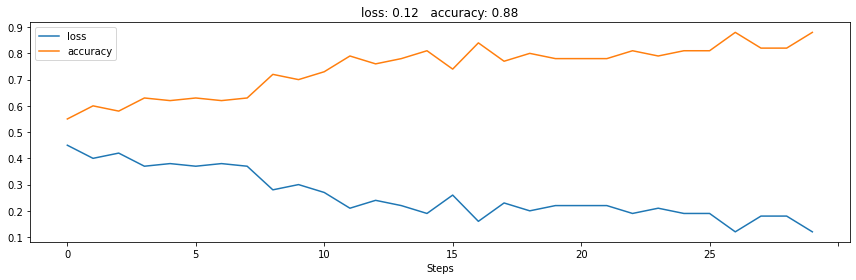

In [ ]:
cifar_canvas.draw_plot([cifar_history["loss"], cifar_history["accuracy"]])

## Visual The loss 

## Test

In [ ]:
  test_error=[]
  def test(Data):
    test_canvas= hl.Canvas()
    test_history = hl.History()
    correct = 0
    total = float(len(Data.test_loader.dataset))
    model =  Net().to(DEVICE)
    model.load_state_dict(torch.load(MODELNAME))
    model.eval()
    i=0
    for images, labels in Data.test_loader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      y = model(images).to(DEVICE)
      pred_labels = y.max(dim=1)[1]
      correct = correct + (pred_labels == labels).sum()
      test_history.log(i,loss=1-correct/total, accuracy=correct/total)
      if i%10==0:
        test_canvas.draw_plot([test_history["loss"], test_history["accuracy"]])
      i+=1

    print("correct: ", correct.item())
    print("total: ", total)
    print("accuracy: ", correct.item()/total)          


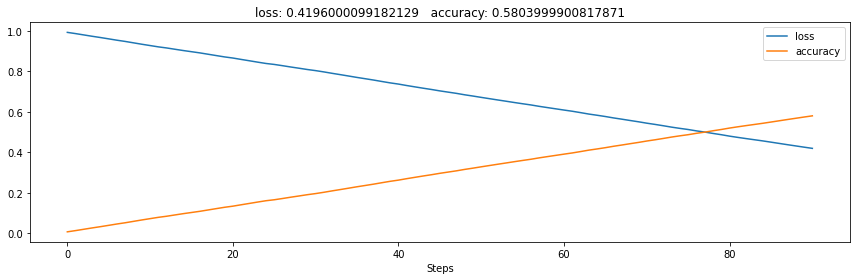

correct:  6379
total:  10000.0
accuracy:  0.6379


In [ ]:
test(Data)